# Zero-shot Image Classification with OpenAI CLIP and OpenVINO™

Zero-shot image classification is a computer vision task to classify images into one of several classes without any prior training or knowledge of the classes.

![zero-shot-pipeline](https://user-images.githubusercontent.com/29454499/207773481-d77cacf8-6cdc-4765-a31b-a1669476d620.png)

[**image source*](https://huggingface.co/tasks/zero-shot-image-classification)


Zero-shot learning resolves several challenges in image retrieval systems. For example, with the rapid growth of categories on the web, it is challenging to index images based on unseen categories. We can associate unseen categories to images with zero-shot learning by exploiting attributes to model's relationship between visual features and labels.
In this tutorial, we will use the [OpenAI CLIP](https://github.com/openai/CLIP) model to perform zero-shot image classification. The notebook contains the following steps:

1. Download the model.
2. Instantiate the PyTorch model.
3. Convert model to OpenVINO IR, using model conversion API.
4. Run CLIP with OpenVINO.

#### Table of contents:
- [Instantiate model](#Instantiate-model)
- [Run PyTorch model inference](#Run-PyTorch-model-inference)
- [Convert model to OpenVINO Intermediate Representation (IR) format.](#Convert-model-to-OpenVINO-Intermediate-Representation-(IR)-format.)
- [Run OpenVINO model](#Run-OpenVINO-model)
    - [Select inference device](#Select-inference-device)
- [Next Steps](#Next-Steps)


## Instantiate model
[back to top ⬆️](#Table-of-contents:)

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on various (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task.
CLIP uses a [ViT](https://arxiv.org/abs/2010.11929) like transformer to get visual features and a causal language model to get the text features. The text and visual features are then projected into a latent space with identical dimensions. The dot product between the projected image and text features is then used as a similarity score.

![clip](https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png)

[**image_source*](https://github.com/openai/CLIP/blob/main/README.md)

You can find more information about this model in the [research paper](https://arxiv.org/abs/2103.00020), [OpenAI blog](https://openai.com/blog/clip/), [model card](https://github.com/openai/CLIP/blob/main/model-card.md) and GitHub [repository](https://github.com/openai/CLIP).

In this notebook, we will use [openai/clip-vit-base-patch16](https://huggingface.co/openai/clip-vit-base-patch16), available via Hugging Face Transformers, but the same steps are applicable for other CLIP family models.

First, we need to create `CLIPModel` class object and initialize it with model configuration and weights, using `from_pretrained` method. The model will be automatically downloaded from Hugging Face Hub and cached for the next usage.
`CLIPProcessor` class is a wrapper for input data preprocessing. It includes both encoding the text using tokenizer and preparing the images.

In [1]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu gradio "openvino>=2023.1.0" "transformers[torch]>=4.30"

In [2]:
from transformers import CLIPProcessor, CLIPModel

# load pre-trained model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
# load preprocessor for model input
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

/home/ea/work/ov_venv/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2023-10-26 14:25:33.940360: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-26 14:25:33.975867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in perfo

## Run PyTorch model inference
[back to top ⬆️](#Table-of-contents:)

To perform classification, define labels and load an image in RGB format. To give the model wider text context and improve guidance, we extend the labels description using the template "This is a photo of a".
Both the list of label descriptions and image should be passed through the processor to obtain a dictionary with input data in the model-specific format. The model predicts an image-text similarity score in raw logits format, which can be normalized to the `[0, 1]` range using the `softmax` function. Then, we select labels with the highest similarity score for the final result.

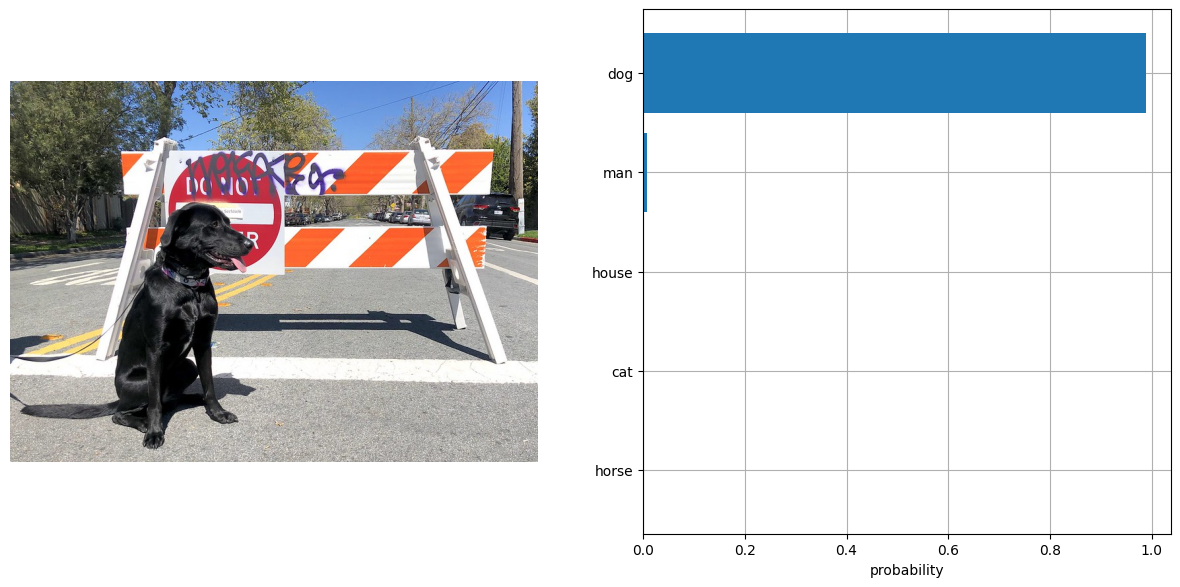

In [3]:
from urllib.request import urlretrieve
from pathlib import Path

from PIL import Image

urlretrieve(
    "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/228-clip-zero-shot-image-classification/visualize.py",
    filename='visualize.py'
)
from visualize import visualize_result


sample_path = Path("data/coco.jpg")
sample_path.parent.mkdir(parents=True, exist_ok=True)
urlretrieve(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    sample_path,
)
image = Image.open(sample_path)

input_labels = ['cat', 'dog', 'wolf', 'tiger', 'man', 'horse', 'frog', 'tree', 'house', 'computer']
text_descriptions = [f"This is a photo of a {label}" for label in input_labels]

inputs = processor(text=text_descriptions, images=[image], return_tensors="pt", padding=True)

results = model(**inputs)
logits_per_image = results['logits_per_image']  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1).detach().numpy()  # we can take the softmax to get the label probabilities
visualize_result(image, input_labels, probs[0])

## Convert model to OpenVINO Intermediate Representation (IR) format.
[back to top ⬆️](#Table-of-contents:)

For best results with OpenVINO, it is recommended to convert the model to OpenVINO IR format. OpenVINO supports PyTorch via Model conversion API.
To convert the PyTorch model to OpenVINO IR format we will use `ov.convert_model` of [model conversion API](https://docs.openvino.ai/2023.3/openvino_docs_model_processing_introduction.html). The `ov.convert_model` Python function returns an OpenVINO Model object ready to load on the device and start making predictions. We can save it on disk for the next usage with `ov.save_model`.


In [4]:
import openvino as ov

model.config.torchscript = True
ov_model = ov.convert_model(model, example_input=dict(inputs))
ov.save_model(ov_model, 'clip-vit-base-patch16.xml')

[ WARNING ]  Please fix your imports. Module %s has been moved to %s. The old module will be deleted in version %s.
/home/ea/work/ov_venv/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:287: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/home/ea/work/ov_venv/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:327: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
/home/ea/work/o

## Run OpenVINO model
[back to top ⬆️](#Table-of-contents:)

The steps for making predictions with the OpenVINO CLIP model are similar to the PyTorch model. Let us check the model result using the same input data from the example above with PyTorch.

In [5]:
from scipy.special import softmax

# create OpenVINO core object instance
core = ov.Core()

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [6]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

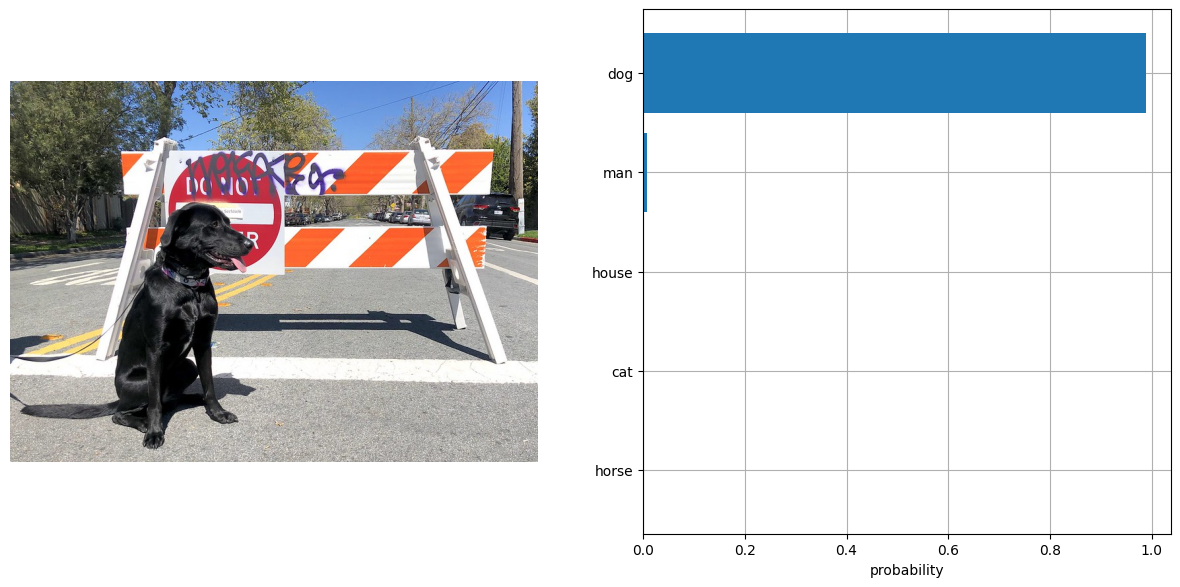

In [7]:
# compile model for loading on device
compiled_model = core.compile_model(ov_model, device.value)
# obtain output tensor for getting predictions
logits_per_image_out = compiled_model.output(0)
# run inference on preprocessed data and get image-text similarity score
ov_logits_per_image = compiled_model(dict(inputs))[logits_per_image_out]
# perform softmax on score
probs = softmax(ov_logits_per_image, axis=1)
# visualize prediction
visualize_result(image, input_labels, probs[0])

Great! Looks like we got the same result.

Now, it is your turn! You can provide your own image and comma-separated list of labels for zero-shot classification.

Feel free to upload an image, using the file upload window and type label names into the text field, using comma as the separator (for example, `cat,dog,bird`)

In [ ]:
import gradio as gr


def classify(image, text):
    """Classify image using classes listing.
    Args:
        image (np.ndarray): image that needs to be classified in CHW format.
        text (str): comma-separated list of class labels
    Returns:
        (dict): Mapping between class labels and class probabilities.
    """
    labels = text.split(",")
    text_descriptions = [f"This is a photo of a {label}" for label in labels]
    inputs = processor(text=text_descriptions, images=[image], return_tensors="np", padding=True)
    ov_logits_per_image = compiled_model(dict(inputs))[logits_per_image_out]
    probs = softmax(ov_logits_per_image, axis=1)[0]
    
    return {label: float(prob) for label, prob in zip(labels, probs)}


demo = gr.Interface(
    classify,
    [
        gr.Image(label="Image", type="pil"),
        gr.Textbox(label="Labels", info="Comma-separated list of class labels"),
    ],
    gr.Label(label="Result"),
    examples=[[sample_path, "cat,dog,bird"]],
)
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

Running on local URL:  http://127.0.0.1:7861
Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running on public URL: https://4ec3df1c48219763b1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Next Steps
[back to top ⬆️](#Table-of-contents:)

Open the [228-clip-zero-shot-quantize](228-clip-zero-shot-quantize.ipynb) notebook to quantize the IR model with the Post-training Quantization API of NNCF and compare `FP16` and `INT8` models.